## 전처리한 데이터 가지고 오기

In [8]:
%pip install -q lightgbm scikit-learn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib-korean (from versions: none)
ERROR: No matching distribution found for matplotlib-korean
You should consider upgrading via the 'c:\Users\taka2\.pyenv\pyenv-win\versions\3.10.2\python.exe -m pip install --upgrade pip' command.


In [11]:
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('../data/url_metadata_cleaned.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371357 entries, 0 to 371356
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   url                   371357 non-null  object 
 1   url_type              371357 non-null  int64  
 2   url_len               371357 non-null  int64  
 3   letters_count         371357 non-null  int64  
 4   digits_count          371357 non-null  int64  
 5   special_chars_count   371357 non-null  int64  
 6   shortened             371357 non-null  int64  
 7   is_domain_in_url      371357 non-null  int64  
 8   secure_http           371357 non-null  int64  
 9   have_ip               371357 non-null  bool   
 10  url_region            371357 non-null  object 
 11  root_domain           371227 non-null  object 
 12  redirect_count        371357 non-null  int64  
 13  timeout               371357 non-null  bool   
 14  has_meta_refresh      371357 non-null  bool   
 15  

,url,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,is_domain_in_url,secure_http,have_ip,...,has_meta_refresh,duration_sec,meta_count,link_count,title_count,has_title,has_meta_description,has_og_image,has_og_title,has_link_stylesheet
0,bopsecrets.org/rexroth/cr/1.htm,0,31,25,1,5,0,0,0,False,...,False,6.41,7.0,1.0,1.0,True,False,False,False,True
1,espn.go.com/nba/player/_/id/3457/brandon-rush,0,45,31,4,10,0,0,0,False,...,False,88.17,31.0,62.0,1.0,True,True,True,True,True
2,yourbittorrent.com/?q=anthony-hamilton-soulife,0,46,40,0,6,0,0,0,False,...,False,21.12,4.0,11.0,1.0,True,False,False,False,True
3,allmusic.com/album/crazy-from-the-heat-r16990,0,45,33,5,7,0,0,0,False,...,False,131.85,30.0,52.0,1.0,True,True,True,True,True
4,corporationwiki.com/Ohio/Columbus/frank-s-bens...,0,62,47,7,8,0,0,0,False,...,False,170.81,27.0,15.0,1.0,True,True,True,True,True


In [4]:
label_map = {0: "benign (정상)", 1: "defacement (악성)", 2: "phishing (피싱)", 3: "malware (멀웨어)"}

type_counts = df["url_type"].value_counts().rename_axis("url_type").reset_index(name="count")
type_counts["label"] = type_counts["url_type"].map(label_map)
type_counts["proportion (%)"] = (type_counts["count"] / type_counts["count"].sum() * 100).round(2)

print(type_counts)


   url_type   count            label  proportion (%)
0         0  277217      benign (정상)           74.65
1         2   46462    phishing (피싱)           12.51
2         1   42781  defacement (악성)           11.52
3         3    4897    malware (멀웨어)            1.32


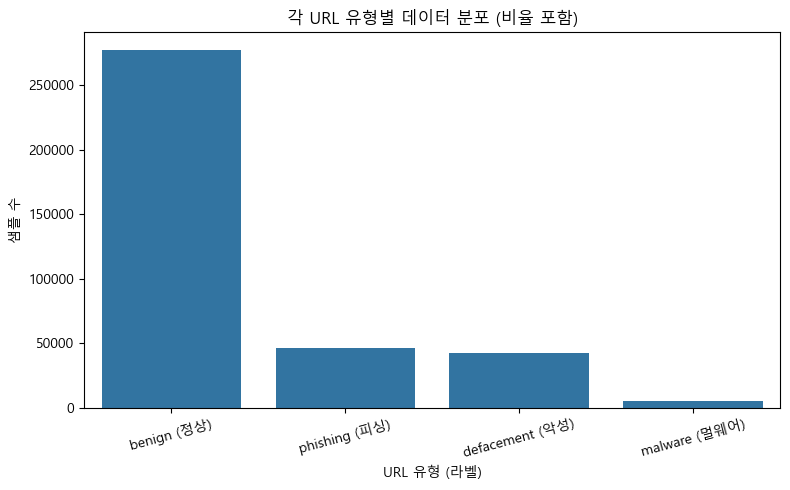

In [12]:
# Windows에서 기본 제공되는 한글 폰트 설정
matplotlib.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 예제 그래프
plt.figure(figsize=(8, 5))
sns.barplot(x="label", y="count", data=type_counts)
plt.title("각 URL 유형별 데이터 분포 (비율 포함)")
plt.xlabel("URL 유형 (라벨)")
plt.ylabel("샘플 수")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

特徴量とラベルに分割

## SMOTEで不均衡を解消し、LightGBMで再学習

### 1. SMOTE で学習データのバランスを取る

In [ ]:
%pip install -q imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\taka2\.pyenv\pyenv-win\versions\3.10.2\python.exe -m pip install --upgrade pip' command.


In [15]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [13]:
# 予測対象（目的変数）
y = df['url_type']

# 特徴量（不要列を除く）
X = df.drop(columns=['url_type'])

X = X.select_dtypes(exclude=['object'])  # 数値型のみ使用（文字列は除外）

学習・検証データに分割

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
# 5. クラス分布の確認（元の）
print("📊 元の学習データのクラス分布:", Counter(y_train))

📊 元の学習データのクラス分布: Counter({0: 221773, 2: 37169, 1: 34225, 3: 3918})


In [21]:
# 6. SMOTEで不均衡を解消
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 7. クラス分布の確認（SMOTE後）
print("📊 SMOTE適用後のクラス分布:", Counter(y_train_resampled))

📊 SMOTE適用後のクラス分布: Counter({2: 221773, 0: 221773, 1: 221773, 3: 221773})


LightGBMデータ形式に変換

In [22]:
# 1. LightGBM 用データセットの準備（SMOTE後のデータで）
train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)
test_data = lgb.Dataset(X_test, label=y_test)

ハイパーパラメータ設定とモデル学習

In [23]:
# 2. パラメータ設定
params = {
    'objective': 'multiclass',
    'num_class': y.nunique(),  # 4クラス
    'metric': 'multi_logloss',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
}

# 3. モデル学習
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=100,
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.log_evaluation(period=10)
    ]
)

Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.629366	valid_1's multi_logloss: 0.702365
[20]	training's multi_logloss: 0.46101	valid_1's multi_logloss: 0.539857
[30]	training's multi_logloss: 0.394939	valid_1's multi_logloss: 0.470405
[40]	training's multi_logloss: 0.360405	valid_1's multi_logloss: 0.436505
[50]	training's multi_logloss: 0.33628	valid_1's multi_logloss: 0.411826
[60]	training's multi_logloss: 0.31737	valid_1's multi_logloss: 0.393342
[70]	training's multi_logloss: 0.303586	valid_1's multi_logloss: 0.380021
[80]	training's multi_logloss: 0.291586	valid_1's multi_logloss: 0.369716
[90]	training's multi_logloss: 0.27999	valid_1's multi_logloss: 0.359568
[100]	training's multi_logloss: 0.270181	valid_1's multi_logloss: 0.350163
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.270181	valid_1's multi_logloss: 0.350163


予測と評価

In [24]:
# 4. 予測と評価
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

print("📊 Classification Report")
print(classification_report(y_test, y_pred, target_names=[
    "benign (정상)", "defacement (악성)", "phishing (피싱)", "malware (멀웨어)"
]))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))


📊 Classification Report
                 precision    recall  f1-score   support

    benign (정상)       0.95      0.88      0.91     55444
defacement (악성)       0.86      0.98      0.92      8556
  phishing (피싱)       0.51      0.65      0.57      9293
  malware (멀웨어)       0.72      0.88      0.79       979

       accuracy                           0.86     74272
      macro avg       0.76      0.85      0.80     74272
   weighted avg       0.88      0.86      0.87     74272

🧩 Confusion Matrix
[[48804   708  5838    94]
 [   50  8419    18    69]
 [ 2417   638  6060   178]
 [   30    46    37   866]]


重要な特徴量を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

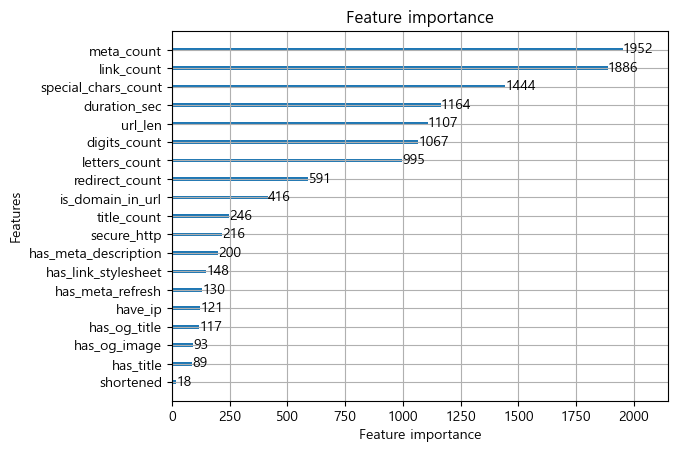

In [25]:
lgb.plot_importance(model, max_num_features=20)

## Optunaによる自動チューニング

In [27]:
%pip install -q optuna

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\taka2\.pyenv\pyenv-win\versions\3.10.2\python.exe -m pip install --upgrade pip' command.


In [29]:
import optuna
from sklearn.metrics import f1_score
import lightgbm as lgb

def objective(trial):
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': y.nunique(),
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    dtrain = lgb.Dataset(X_train_resampled, label=y_train_resampled)
    dvalid = lgb.Dataset(X_test, label=y_test, reference=dtrain)

    model = lgb.train(param, dtrain, valid_sets=[dvalid], num_boost_round=100,
                      callbacks=[
                          lgb.early_stopping(10),
                          lgb.log_evaluation(0)  # ← 表示したいなら 10 にする
                      ])

    preds = model.predict(X_test).argmax(axis=1)
    f1 = f1_score(y_test, preds, average='macro')
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # 試行回数は必要に応じて増やす

print("Best params:", study.best_trial.params)


[I 2025-05-15 16:57:52,372] A new study created in memory with name: no-name-7c0e5046-d924-4c52-90a8-25ed3640cbd3


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.268129


[I 2025-05-15 16:58:00,600] Trial 0 finished with value: 0.8367150581074094 and parameters: {'learning_rate': 0.20453485776800256, 'num_leaves': 59, 'max_depth': 14, 'min_child_samples': 37, 'subsample': 0.5480713251621585, 'colsample_bytree': 0.6942825361526002}. Best is trial 0 with value: 0.8367150581074094.


Training until validation scores don't improve for 10 rounds


[I 2025-05-15 16:58:04,986] Trial 1 finished with value: 0.7146102344276366 and parameters: {'learning_rate': 0.1873101851900714, 'num_leaves': 92, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.5015847534109272, 'colsample_bytree': 0.715967888785696}. Best is trial 0 with value: 0.8367150581074094.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.461255
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.291904


[I 2025-05-15 16:58:15,168] Trial 2 finished with value: 0.8318791908860104 and parameters: {'learning_rate': 0.10541727740645358, 'num_leaves': 81, 'max_depth': 12, 'min_child_samples': 86, 'subsample': 0.842632601805807, 'colsample_bytree': 0.5795653311330335}. Best is trial 0 with value: 0.8367150581074094.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.240075


[I 2025-05-15 16:58:26,197] Trial 3 finished with value: 0.8546464688156242 and parameters: {'learning_rate': 0.2407340568360851, 'num_leaves': 121, 'max_depth': 13, 'min_child_samples': 52, 'subsample': 0.8664479878518418, 'colsample_bytree': 0.5743206351711007}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.525417


[I 2025-05-15 16:58:40,083] Trial 4 finished with value: 0.7735772714716352 and parameters: {'learning_rate': 0.01769265417584629, 'num_leaves': 142, 'max_depth': 10, 'min_child_samples': 99, 'subsample': 0.8440684230319382, 'colsample_bytree': 0.56497743472806}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.296971


[I 2025-05-15 16:58:48,523] Trial 5 finished with value: 0.8235582683535927 and parameters: {'learning_rate': 0.13831440221467545, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 45, 'subsample': 0.5112069213301569, 'colsample_bytree': 0.6249520422057593}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.301947


[I 2025-05-15 16:58:54,532] Trial 6 finished with value: 0.8229636945741357 and parameters: {'learning_rate': 0.15342735335356109, 'num_leaves': 38, 'max_depth': 14, 'min_child_samples': 49, 'subsample': 0.5916621684371295, 'colsample_bytree': 0.8838870820423945}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.305687


[I 2025-05-15 16:59:01,368] Trial 7 finished with value: 0.8223689689354661 and parameters: {'learning_rate': 0.1622730392313499, 'num_leaves': 39, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.7696401113604723, 'colsample_bytree': 0.6487382270233044}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.272146


[I 2025-05-15 16:59:11,556] Trial 8 finished with value: 0.8378560564491652 and parameters: {'learning_rate': 0.15461197262750834, 'num_leaves': 79, 'max_depth': 12, 'min_child_samples': 84, 'subsample': 0.7401022826376837, 'colsample_bytree': 0.507921203822438}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.287515


[I 2025-05-15 16:59:21,339] Trial 9 finished with value: 0.8282065306319608 and parameters: {'learning_rate': 0.1803859118758971, 'num_leaves': 45, 'max_depth': 13, 'min_child_samples': 35, 'subsample': 0.5372630403918018, 'colsample_bytree': 0.5912730342024725}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.258736


[I 2025-05-15 16:59:29,369] Trial 10 finished with value: 0.845486777573264 and parameters: {'learning_rate': 0.29666522506304854, 'num_leaves': 133, 'max_depth': 7, 'min_child_samples': 66, 'subsample': 0.9600918932888958, 'colsample_bytree': 0.8379628309501393}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.280501


[I 2025-05-15 16:59:35,517] Trial 11 finished with value: 0.8301973919831994 and parameters: {'learning_rate': 0.29642806341685496, 'num_leaves': 136, 'max_depth': 6, 'min_child_samples': 66, 'subsample': 0.9964186993180429, 'colsample_bytree': 0.842054903265213}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.284625


[I 2025-05-15 16:59:41,877] Trial 12 finished with value: 0.8293478931717526 and parameters: {'learning_rate': 0.2900165094325923, 'num_leaves': 115, 'max_depth': 6, 'min_child_samples': 65, 'subsample': 0.997691356182548, 'colsample_bytree': 0.7922384987740422}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.266091


[I 2025-05-15 16:59:49,833] Trial 13 finished with value: 0.8415951896167815 and parameters: {'learning_rate': 0.2468418110876237, 'num_leaves': 114, 'max_depth': 7, 'min_child_samples': 61, 'subsample': 0.9118484438556428, 'colsample_bytree': 0.9910896788513623}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds


[I 2025-05-15 16:59:53,907] Trial 14 finished with value: 0.7293744969632107 and parameters: {'learning_rate': 0.24060533943806206, 'num_leaves': 118, 'max_depth': 3, 'min_child_samples': 78, 'subsample': 0.9100119160628646, 'colsample_bytree': 0.9273275074327596}. Best is trial 3 with value: 0.8546464688156242.


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.439189
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.241699


[I 2025-05-15 17:00:02,825] Trial 15 finished with value: 0.8520055168482354 and parameters: {'learning_rate': 0.2486305513349375, 'num_leaves': 129, 'max_depth': 9, 'min_child_samples': 59, 'subsample': 0.9121001332728539, 'colsample_bytree': 0.7961230548114913}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.244834


[I 2025-05-15 17:00:11,356] Trial 16 finished with value: 0.8492203892447561 and parameters: {'learning_rate': 0.24287026654404678, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.7182950189543522, 'colsample_bytree': 0.7688663543471315}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.393543


[I 2025-05-15 17:00:18,839] Trial 17 finished with value: 0.7678372325796465 and parameters: {'learning_rate': 0.09746996691756685, 'num_leaves': 21, 'max_depth': 10, 'min_child_samples': 52, 'subsample': 0.8236424100163529, 'colsample_bytree': 0.5037942958517937}. Best is trial 3 with value: 0.8546464688156242.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.233709


[I 2025-05-15 17:00:29,581] Trial 18 finished with value: 0.8564432971900285 and parameters: {'learning_rate': 0.22145023500321342, 'num_leaves': 147, 'max_depth': 15, 'min_child_samples': 75, 'subsample': 0.6573278816055506, 'colsample_bytree': 0.691194990871715}. Best is trial 18 with value: 0.8564432971900285.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.233031


[I 2025-05-15 17:00:40,698] Trial 19 finished with value: 0.8555085440951102 and parameters: {'learning_rate': 0.21678015912302864, 'num_leaves': 150, 'max_depth': 15, 'min_child_samples': 74, 'subsample': 0.6630292012364244, 'colsample_bytree': 0.6722499751949929}. Best is trial 18 with value: 0.8564432971900285.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.233646


[I 2025-05-15 17:00:52,027] Trial 20 finished with value: 0.8544923004053149 and parameters: {'learning_rate': 0.21609680508706455, 'num_leaves': 148, 'max_depth': 15, 'min_child_samples': 100, 'subsample': 0.6546127474576711, 'colsample_bytree': 0.702347170055928}. Best is trial 18 with value: 0.8564432971900285.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.23414


[I 2025-05-15 17:01:03,775] Trial 21 finished with value: 0.8555392846101203 and parameters: {'learning_rate': 0.21716535310176807, 'num_leaves': 150, 'max_depth': 15, 'min_child_samples': 76, 'subsample': 0.6604150243081633, 'colsample_bytree': 0.6426834130525583}. Best is trial 18 with value: 0.8564432971900285.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.234033


[I 2025-05-15 17:01:13,773] Trial 22 finished with value: 0.8567484802888685 and parameters: {'learning_rate': 0.21529263310729035, 'num_leaves': 150, 'max_depth': 15, 'min_child_samples': 74, 'subsample': 0.654626294771191, 'colsample_bytree': 0.656706829860911}. Best is trial 22 with value: 0.8567484802888685.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.23189


[I 2025-05-15 17:01:23,485] Trial 23 finished with value: 0.8587478916251897 and parameters: {'learning_rate': 0.26607181395216234, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 91, 'subsample': 0.6257440273173689, 'colsample_bytree': 0.7410663426257897}. Best is trial 23 with value: 0.8587478916251897.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.237499


[I 2025-05-15 17:01:32,998] Trial 24 finished with value: 0.8532200002286441 and parameters: {'learning_rate': 0.2685736029651022, 'num_leaves': 106, 'max_depth': 14, 'min_child_samples': 90, 'subsample': 0.6063344726990332, 'colsample_bytree': 0.7340551818430474}. Best is trial 23 with value: 0.8587478916251897.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.232836


[I 2025-05-15 17:01:42,149] Trial 25 finished with value: 0.8561354146257469 and parameters: {'learning_rate': 0.2702318262961831, 'num_leaves': 128, 'max_depth': 13, 'min_child_samples': 92, 'subsample': 0.6964549127817921, 'colsample_bytree': 0.7487384964018898}. Best is trial 23 with value: 0.8587478916251897.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.230678


[I 2025-05-15 17:01:53,862] Trial 26 finished with value: 0.8576453984528057 and parameters: {'learning_rate': 0.26536373729001606, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 72, 'subsample': 0.6263858270902426, 'colsample_bytree': 0.6707493814307928}. Best is trial 23 with value: 0.8587478916251897.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.233736


[I 2025-05-15 17:02:05,028] Trial 27 finished with value: 0.8572102100183625 and parameters: {'learning_rate': 0.2708123286468255, 'num_leaves': 138, 'max_depth': 14, 'min_child_samples': 83, 'subsample': 0.5945469511492614, 'colsample_bytree': 0.622119906248157}. Best is trial 23 with value: 0.8587478916251897.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.240152


[I 2025-05-15 17:02:15,014] Trial 28 finished with value: 0.8531044176156921 and parameters: {'learning_rate': 0.26443982655154114, 'num_leaves': 105, 'max_depth': 11, 'min_child_samples': 84, 'subsample': 0.6029051268635752, 'colsample_bytree': 0.6210512533967548}. Best is trial 23 with value: 0.8587478916251897.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.454933


[I 2025-05-15 17:02:27,124] Trial 29 finished with value: 0.7700453126643041 and parameters: {'learning_rate': 0.027916380396121043, 'num_leaves': 74, 'max_depth': 14, 'min_child_samples': 92, 'subsample': 0.5739812381093055, 'colsample_bytree': 0.534667546463284}. Best is trial 23 with value: 0.8587478916251897.


Best params: {'learning_rate': 0.26607181395216234, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 91, 'subsample': 0.6257440273173689, 'colsample_bytree': 0.7410663426257897}


Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 0.308519	valid_1's multi_logloss: 0.394209
[20]	training's multi_logloss: 0.217106	valid_1's multi_logloss: 0.306871
[30]	training's multi_logloss: 0.1816	valid_1's multi_logloss: 0.276042
[40]	training's multi_logloss: 0.161035	valid_1's multi_logloss: 0.261638
[50]	training's multi_logloss: 0.147394	valid_1's multi_logloss: 0.253529
[60]	training's multi_logloss: 0.135146	valid_1's multi_logloss: 0.245624
[70]	training's multi_logloss: 0.125732	valid_1's multi_logloss: 0.240431
[80]	training's multi_logloss: 0.118334	valid_1's multi_logloss: 0.23664
[90]	training's multi_logloss: 0.113001	valid_1's multi_logloss: 0.234469
[100]	training's multi_logloss: 0.107731	valid_1's multi_logloss: 0.23189
[110]	training's multi_logloss: 0.10265	valid_1's multi_logloss: 0.229795
[120]	training's multi_logloss: 0.098603	valid_1's multi_logloss: 0.228834
[130]	training's multi_logloss: 0.0948122	valid_1's m

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

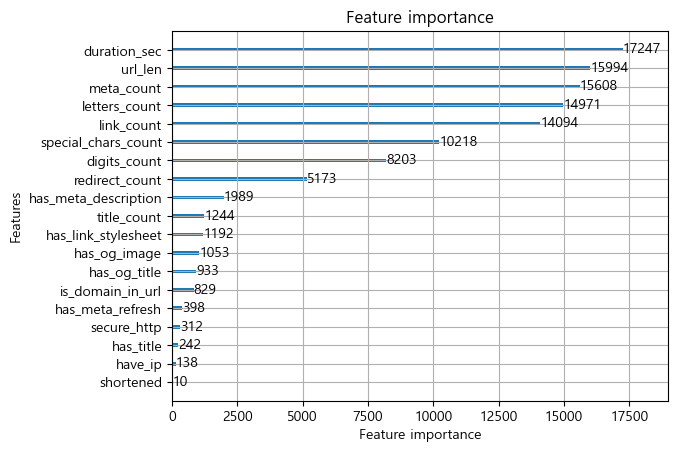

In [30]:
# 1. ベストパラメータを取得
best_params = study.best_trial.params

# 2. 必須のパラメータを明示的に追加
best_params.update({
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': y.nunique(),
    'verbosity': -1,
})

# 3. データセット定義（再利用）
dtrain = lgb.Dataset(X_train_resampled, label=y_train_resampled)
dtest = lgb.Dataset(X_test, label=y_test)

# 4. LightGBM 学習（ベストパラメータで）
model = lgb.train(
    best_params,
    dtrain,
    valid_sets=[dtrain, dtest],
    num_boost_round=200,
    callbacks=[
        lgb.early_stopping(10),
        lgb.log_evaluation(10)
    ]
)

# 5. 予測と評価
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

print("📊 Classification Report (ベストパラメータ適用後)")
print(classification_report(y_test, y_pred, target_names=[
    "benign (정상)", "defacement (악성)", "phishing (피싱)", "malware (멀웨어)"
]))

print("🧩 Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

# 6. 特徴量重要度プロット
lgb.plot_importance(model, max_num_features=20)
